In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import joblib
import seaborn as sns
from pathlib import Path


In [36]:
df_new = pd.read_csv('data/dt_tbl1.csv', skiprows=1)

# The second row (now first row after skipping) becomes the header automatically
# Drop the now-redundant header row if it’s still inside the data
if df_new.columns[0] == '1':
    df_new = df_new[1:].reset_index(drop=True)


In [37]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 46 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   b            2126 non-null   float64
 1   e            2126 non-null   float64
 2   AC           2126 non-null   float64
 3   FM           2127 non-null   float64
 4   UC           2127 non-null   float64
 5   DL           2128 non-null   float64
 6   DS           2128 non-null   float64
 7   DP           2128 non-null   float64
 8   DR           2128 non-null   float64
 9   Unnamed: 9   0 non-null      float64
 10  LB           2126 non-null   float64
 11  AC.1         2126 non-null   float64
 12  FM.1         2127 non-null   float64
 13  UC.1         2127 non-null   float64
 14  DL.1         2128 non-null   float64
 15  DS.1         2128 non-null   float64
 16  DP.1         2128 non-null   float64
 17  ASTV         2127 non-null   float64
 18  MSTV         2127 non-null   float64
 19  ALTV  

In [38]:
# Drop all columns whose names start with 'Unnamed'
df_new = df_new.loc[:, ~df_new.columns.str.contains('^Unnamed')]

#  reset index after cleaning
df_new = df_new.reset_index(drop=True)

In [39]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 42 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   b         2126 non-null   float64
 1   e         2126 non-null   float64
 2   AC        2126 non-null   float64
 3   FM        2127 non-null   float64
 4   UC        2127 non-null   float64
 5   DL        2128 non-null   float64
 6   DS        2128 non-null   float64
 7   DP        2128 non-null   float64
 8   DR        2128 non-null   float64
 9   LB        2126 non-null   float64
 10  AC.1      2126 non-null   float64
 11  FM.1      2127 non-null   float64
 12  UC.1      2127 non-null   float64
 13  DL.1      2128 non-null   float64
 14  DS.1      2128 non-null   float64
 15  DP.1      2128 non-null   float64
 16  ASTV      2127 non-null   float64
 17  MSTV      2127 non-null   float64
 18  ALTV      2127 non-null   float64
 19  MLTV      2127 non-null   float64
 20  Width     2126 non-null   floa

In [40]:
#selecting only the necessary parameters
df_new = df_new.drop(df_new.columns[list(range(0, 9)) + list(range(30, 40))], axis=1)


In [41]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        2126 non-null   float64
 1   AC.1      2126 non-null   float64
 2   FM.1      2127 non-null   float64
 3   UC.1      2127 non-null   float64
 4   DL.1      2128 non-null   float64
 5   DS.1      2128 non-null   float64
 6   DP.1      2128 non-null   float64
 7   ASTV      2127 non-null   float64
 8   MSTV      2127 non-null   float64
 9   ALTV      2127 non-null   float64
 10  MLTV      2127 non-null   float64
 11  Width     2126 non-null   float64
 12  Min       2126 non-null   float64
 13  Max       2126 non-null   float64
 14  Nmax      2126 non-null   float64
 15  Nzeros    2126 non-null   float64
 16  Mode      2126 non-null   float64
 17  Mean      2126 non-null   float64
 18  Median    2126 non-null   float64
 19  Variance  2126 non-null   float64
 20  Tendency  2126 non-null   floa

In [42]:
df_new.shape

(2129, 23)

In [43]:
df_new.head()

,LB,AC.1,FM.1,UC.1,DL.1,DS.1,DP.1,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,9.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,6.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,6.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,6.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,2.0,1.0


In [44]:
df_new.describe()

,LB,AC.1,FM.1,UC.1,DL.1,DS.1,DP.1,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
count,2126.000000,2126.000000,2127.000000,2127.000000,2128.000000,2128.000000,2128.000000,2127.000000,2127.000000,2127.000000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009702,0.004371,0.001895,0.000004,0.000161,47.008933,1.335449,9.884814,...,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,4.509878,1.304327
std,9.840844,0.003866,0.047762,0.002954,0.002973,0.000061,0.000599,17.210648,0.891543,18.476534,...,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,3.026883,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.000000,...,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.000000,...,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,2.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.000000,...,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,4.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.000000,...,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,7.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.000000,...,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,10.000000,3.000000


In [45]:
df_new.isnull().sum()


LB          3
AC.1        3
FM.1        2
UC.1        2
DL.1        1
DS.1        1
DP.1        1
ASTV        2
MSTV        2
ALTV        2
MLTV        2
Width       3
Min         3
Max         3
Nmax        3
Nzeros      3
Mode        3
Mean        3
Median      3
Variance    3
Tendency    3
CLASS       3
NSP         3
dtype: int64

In [46]:
#missing vals is less that 0.14%
#Using median (not mean) since medical signals can have outliers or non-normal distributions
df_new = df_new.fillna(df_new.median(numeric_only=True))


In [47]:
df_new.isnull().sum()

LB          0
AC.1        0
FM.1        0
UC.1        0
DL.1        0
DS.1        0
DP.1        0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
CLASS       0
NSP         0
dtype: int64

In [48]:
df_new.nunique(axis=0)

LB           48
AC.1         20
FM.1        102
UC.1         16
DL.1         16
DS.1          2
DP.1          6
ASTV         75
MSTV         57
ALTV         87
MLTV        249
Width       155
Min         109
Max          86
Nmax         18
Nzeros        9
Mode         88
Mean        103
Median       95
Variance    133
Tendency      3
CLASS        10
NSP           3
dtype: int64

In [49]:
# Select numeric columns only
numeric_df = df_new.select_dtypes(include=['float64', 'int64'])

# Loop through each numeric column
for columnName, columnData in numeric_df.items():
    avg = columnData.mean()
    std_dev = columnData.std()
    num_nulls = columnData.isnull().sum()
    num_outliers = ((columnData < (avg - 2 * std_dev)) | (columnData > (avg + 2 * std_dev))).sum()

    print(f"Column Name        : {columnName}")
    print(f"Number of NULLs    : {num_nulls}")
    print(f"Number of Outliers : {num_outliers}")
    print("-----------------------------")


Column Name        : LB
Number of NULLs    : 0
Number of Outliers : 83
-----------------------------
Column Name        : AC.1
Number of NULLs    : 0
Number of Outliers : 125
-----------------------------
Column Name        : FM.1
Number of NULLs    : 0
Number of Outliers : 39
-----------------------------
Column Name        : UC.1
Number of NULLs    : 0
Number of Outliers : 33
-----------------------------
Column Name        : DL.1
Number of NULLs    : 0
Number of Outliers : 151
-----------------------------
Column Name        : DS.1
Number of NULLs    : 0
Number of Outliers : 8
-----------------------------
Column Name        : DP.1
Number of NULLs    : 0
Number of Outliers : 109
-----------------------------
Column Name        : ASTV
Number of NULLs    : 0
Number of Outliers : 20
-----------------------------
Column Name        : MSTV
Number of NULLs    : 0
Number of Outliers : 84
-----------------------------
Column Name        : ALTV
Number of NULLs    : 0
Number of Outliers : 152

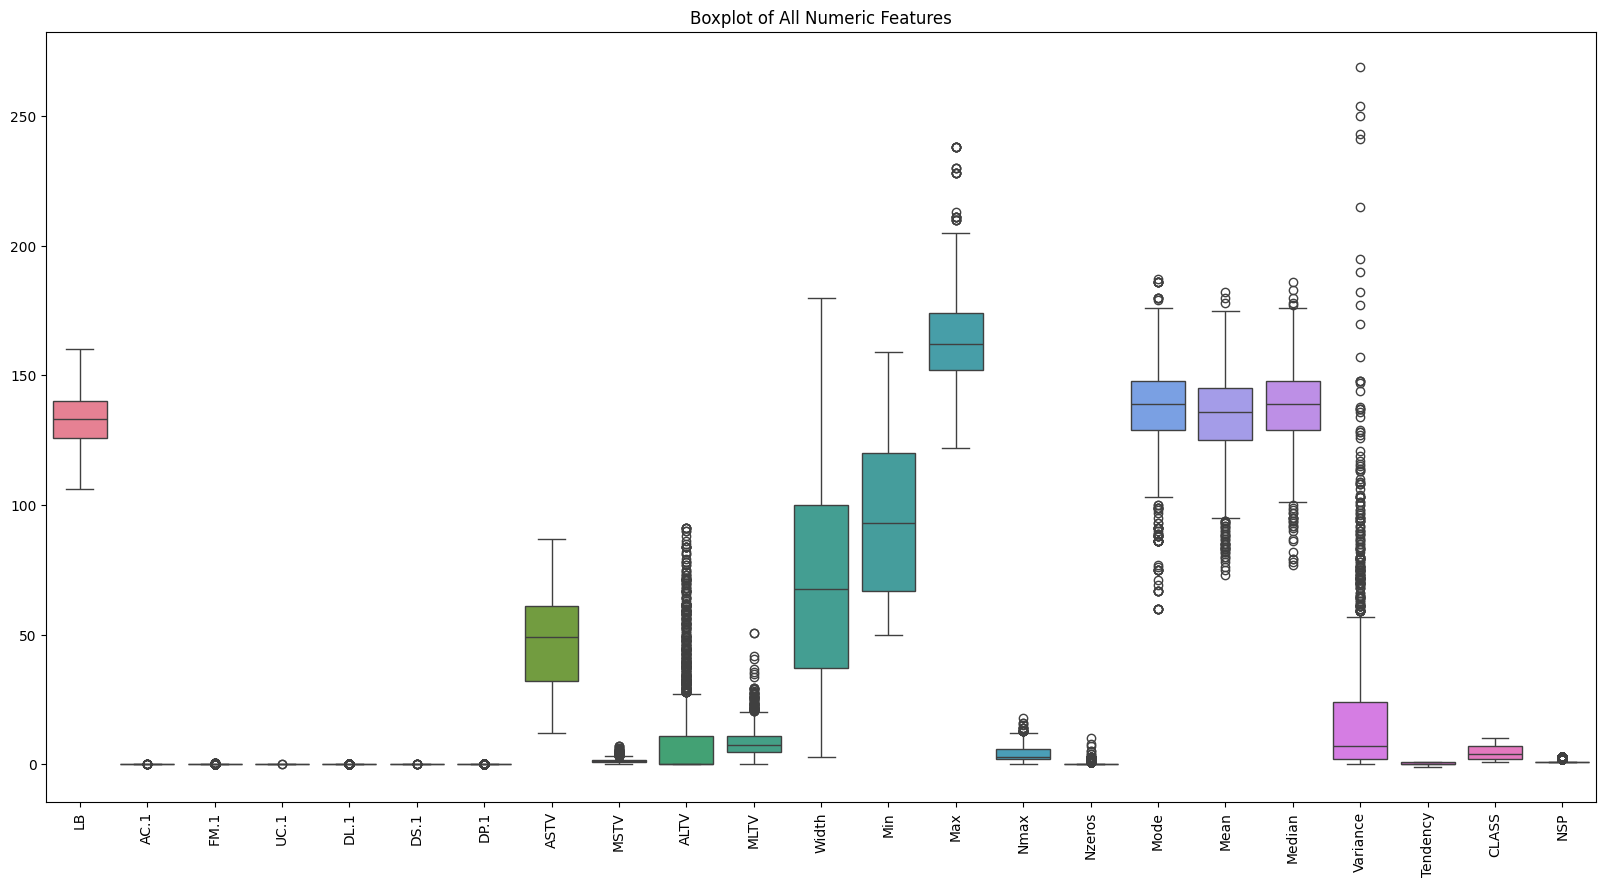

In [50]:
plt.figure(figsize=(20,10))
sns.boxplot(data=numeric_df)
plt.xticks(rotation=90)
plt.title('Boxplot of All Numeric Features')
plt.show()



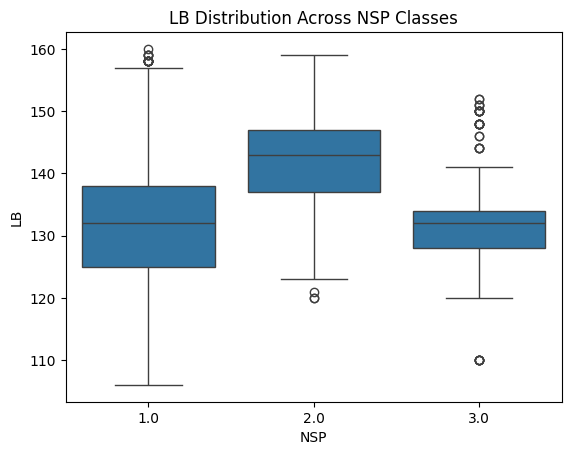

In [51]:
sns.boxplot(x='NSP', y='LB', data=df_new)
plt.title('LB Distribution Across NSP Classes')
plt.show()


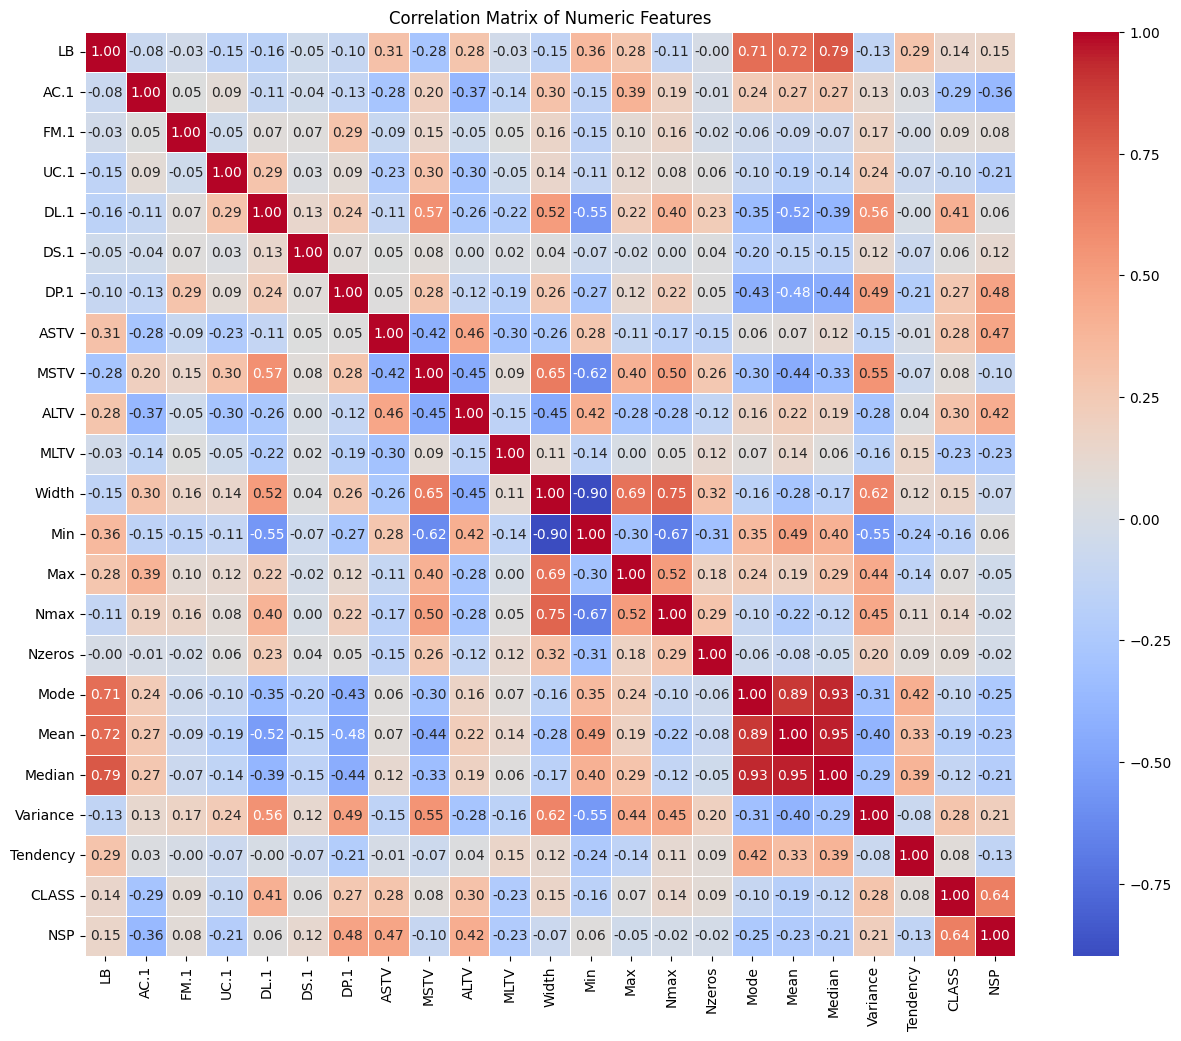

In [52]:


# Compute correlation matrix
corr_matrix = df_new.corr()

# Plot heatmap
plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()


<Axes: ylabel='count'>

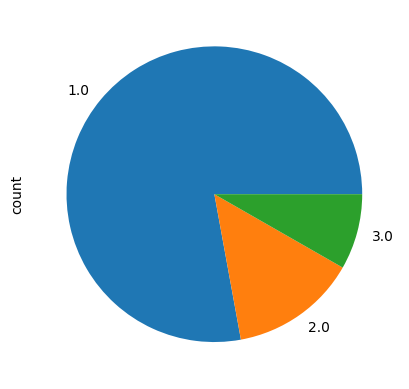

In [53]:
df_new['NSP'].value_counts().plot(kind='pie')

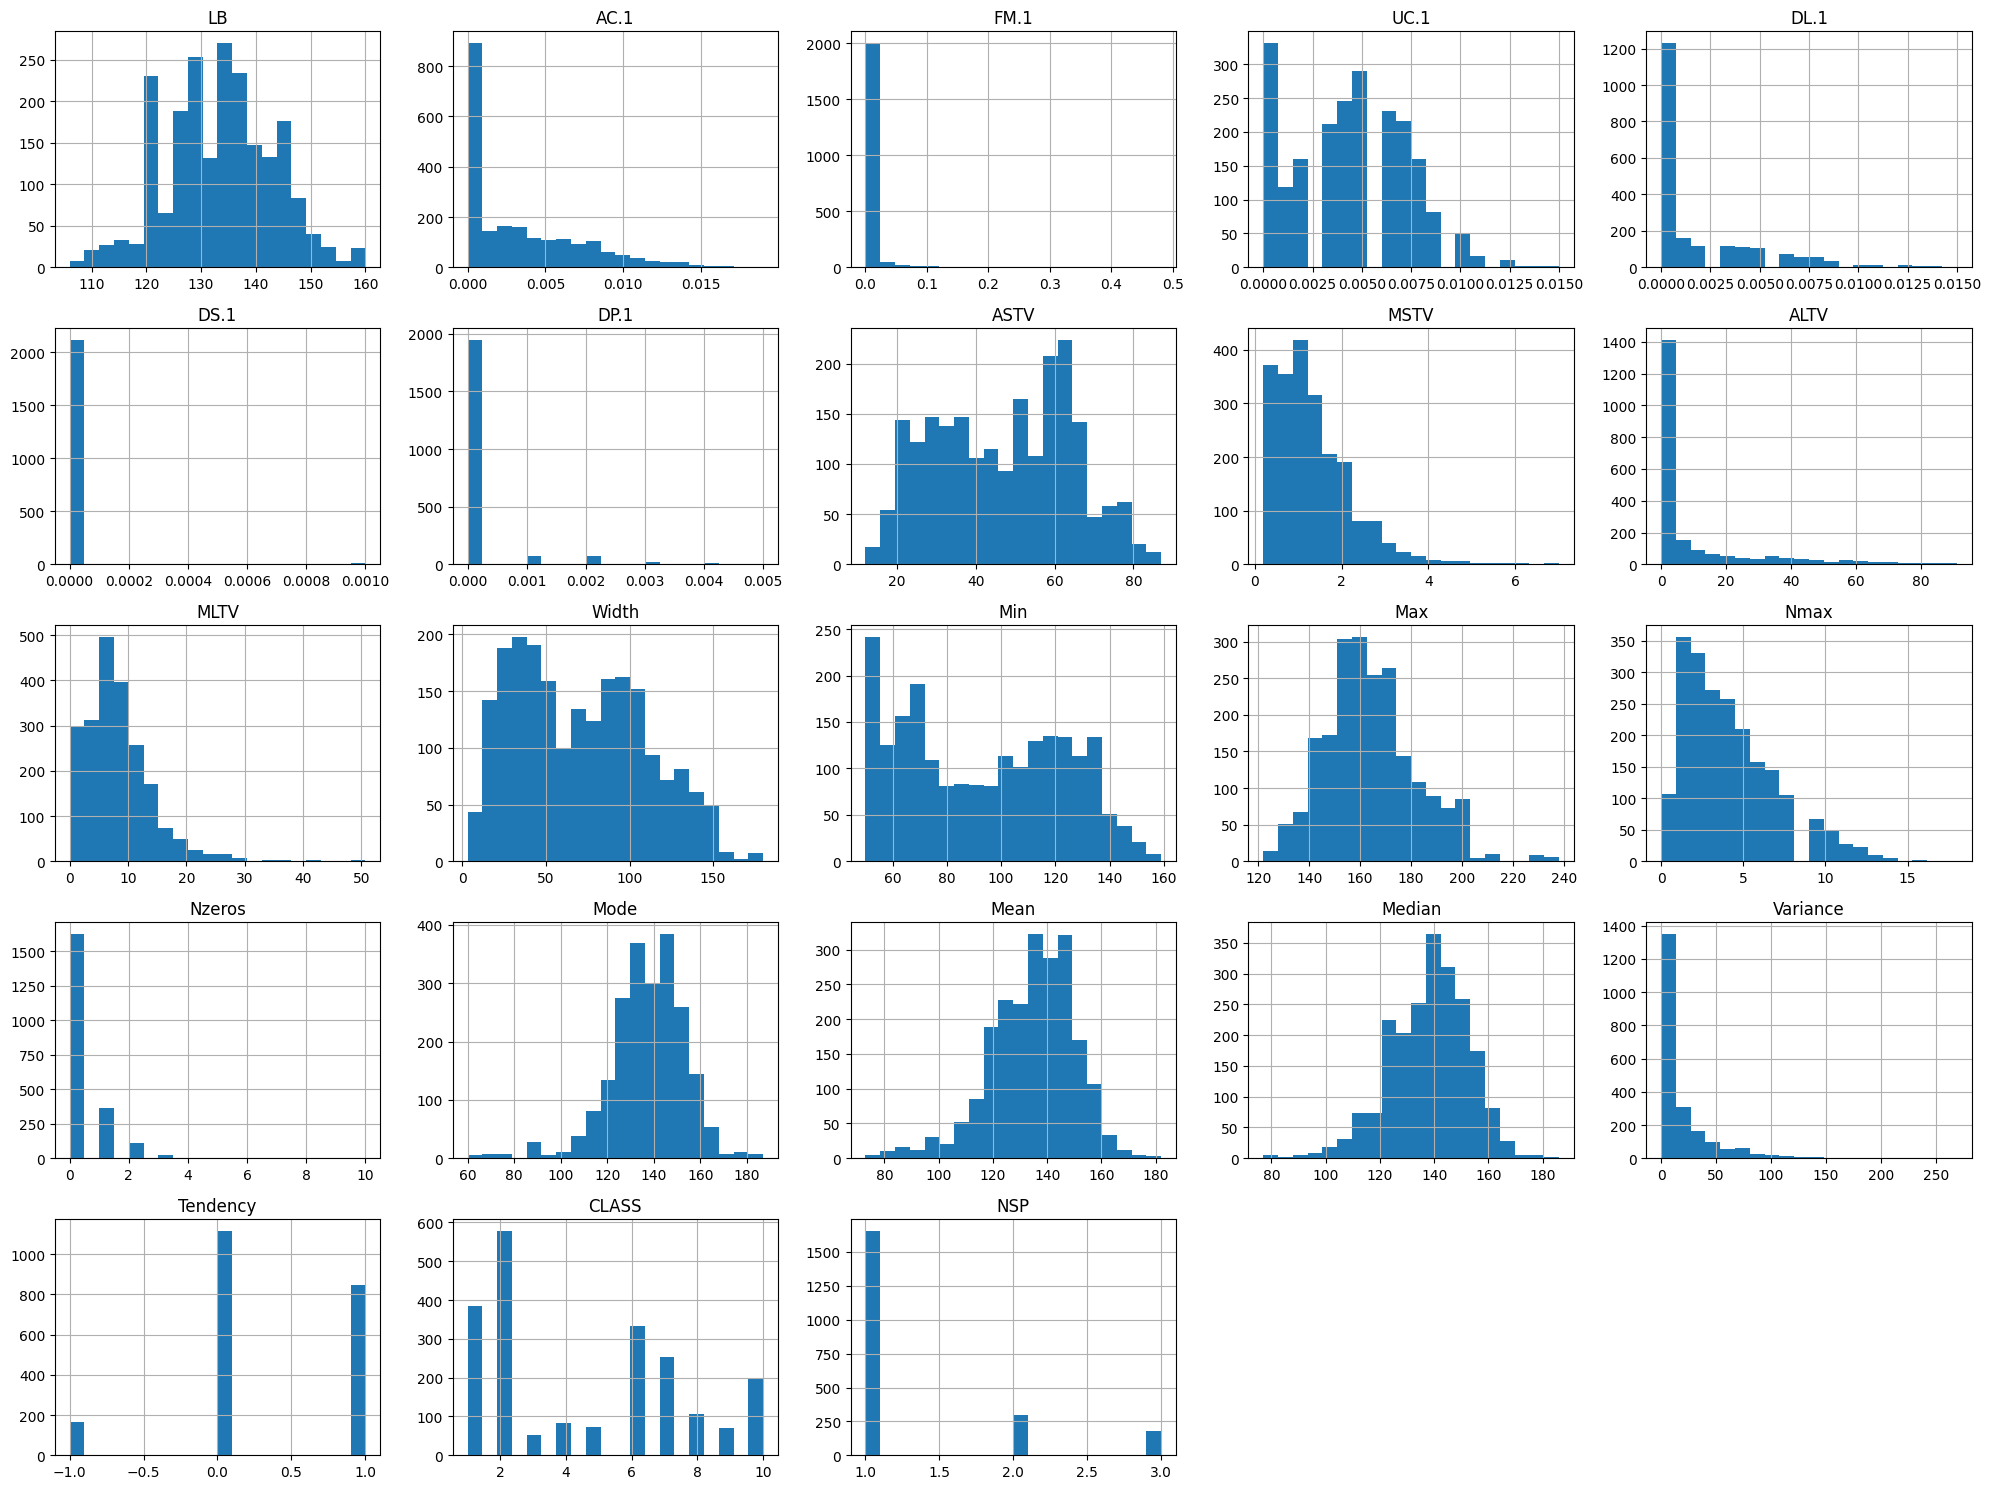

In [54]:


numeric_df = df_new.select_dtypes(include=['float64', 'int64'])

numeric_df.hist(figsize=(20,15), bins=20)
plt.tight_layout()
plt.show()


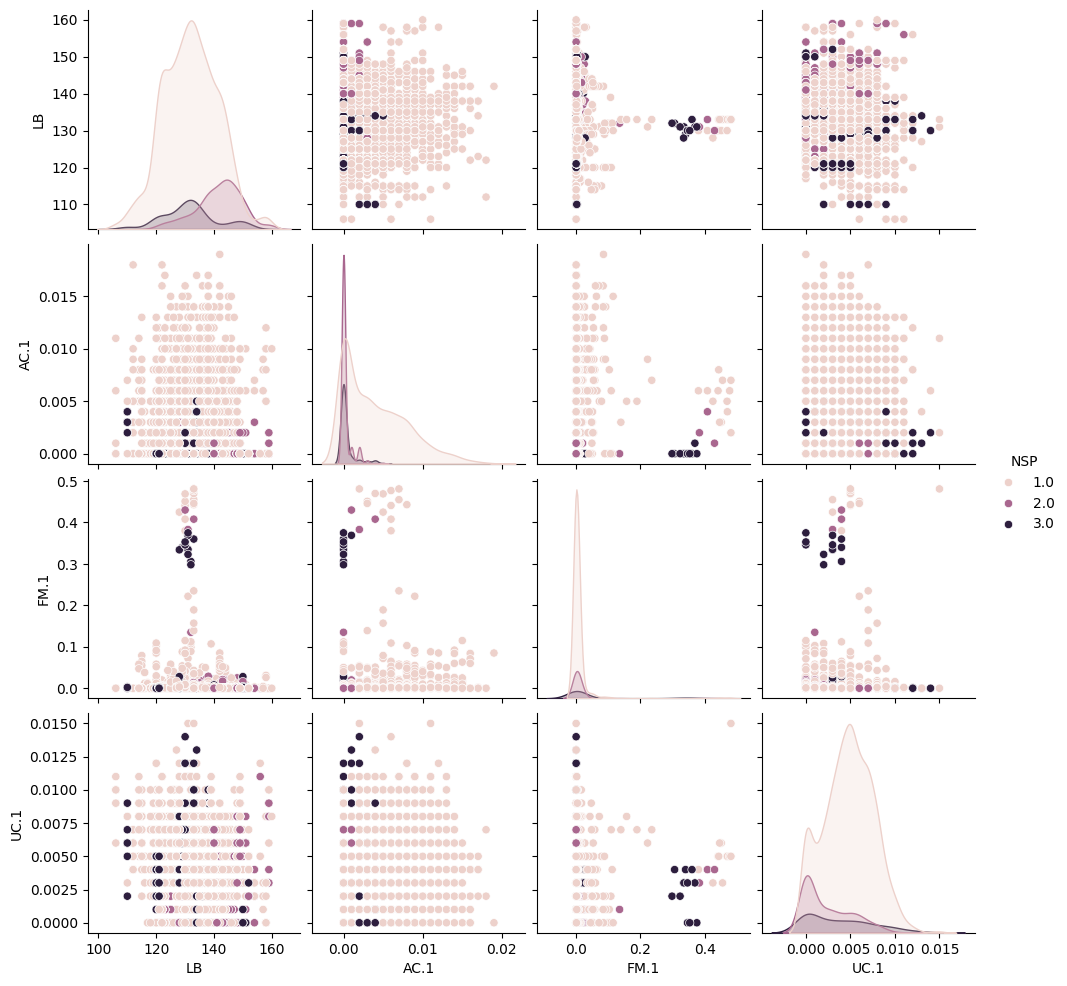

In [55]:
sns.pairplot(df_new, vars=['LB','AC.1','FM.1','UC.1'], hue='NSP')
plt.show()


In [56]:
corr_with_target = df_new.corr()['NSP'].sort_values(ascending=False)
print(corr_with_target)


NSP         1.000000
CLASS       0.643028
DP.1        0.475501
ASTV        0.469912
ALTV        0.423305
Variance    0.206854
LB          0.148147
DS.1        0.119658
FM.1        0.083749
Min         0.063178
DL.1        0.057849
Nzeros     -0.016356
Nmax       -0.023407
Max        -0.045178
Width      -0.068724
MSTV       -0.103786
Tendency   -0.131562
UC.1       -0.205012
Median     -0.205041
MLTV       -0.225443
Mean       -0.227007
Mode       -0.250433
AC.1       -0.363766
Name: NSP, dtype: float64


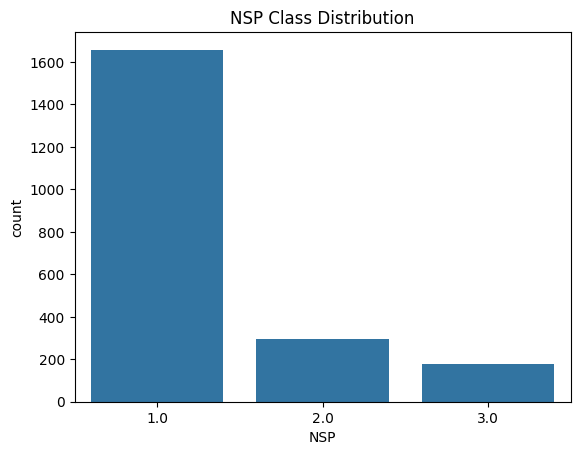

In [57]:
sns.countplot(x='NSP', data=df_new)
plt.title('NSP Class Distribution')
plt.show()


In [58]:
# Drop columns that are not numeric features or the target
cols_to_drop = ['A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP', 'CLASS']
df_new = df_new.drop(columns=[c for c in cols_to_drop if c in df_new.columns])

print("Remaining columns:", df_new.columns.tolist())


Remaining columns: ['LB', 'AC.1', 'FM.1', 'UC.1', 'DL.1', 'DS.1', 'DP.1', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency', 'NSP']


In [59]:
# NSP = target (1=Normal, 2=Suspect, 3=Pathological)
X = df_new.drop(columns=['NSP'])
y = df_new['NSP']

print("Feature shape:", X.shape)
print("Target distribution:\n", y.value_counts())


Feature shape: (2129, 21)
Target distribution:
 NSP
1.0    1658
2.0     295
3.0     176
Name: count, dtype: int64


In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))


Train class distribution:
 NSP
1.0    0.778626
2.0    0.138579
3.0    0.082795
Name: proportion, dtype: float64
Test class distribution:
 NSP
1.0    0.779343
2.0    0.138498
3.0    0.082160
Name: proportion, dtype: float64


In [61]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for clarity
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Scaled training data shape:", X_train_scaled.shape)
X_train_scaled.head()


Scaled training data shape: (1703, 21)


,LB,AC.1,FM.1,UC.1,DL.1,DS.1,DP.1,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,-1.032333,-0.834435,-0.206244,0.896032,0.047600,-0.059461,2.986443,-1.195728,3.331247,-0.535843,...,1.939469,-1.474154,1.782380,1.320689,1.032381,-0.687493,-1.887059,-1.726861,3.316840,-0.526713
1,0.192158,-0.575829,-0.164756,-1.484534,-0.630753,-0.059461,-0.272713,0.652431,-0.828669,0.277039,...,0.626853,-0.794055,0.055794,0.308022,-0.470307,0.101947,0.353185,0.209634,-0.575860,1.113126
2,0.294199,-0.834435,-0.206244,0.896032,0.725953,-0.059461,-0.272713,-0.675933,-0.266518,-0.535843,...,0.395215,-0.828060,-0.501169,-0.367089,-0.470307,-0.080231,-0.094864,-0.067008,-0.169665,1.113126
3,1.722772,-0.834435,-0.206244,-1.144453,-0.630753,-0.059461,-0.272713,1.980795,-1.053530,0.385423,...,-0.685763,1.246243,0.557061,-0.704645,-0.470307,0.891388,0.993254,0.901239,-0.609710,-0.526713
4,0.600322,0.717204,-0.164756,1.916275,1.404306,-0.059461,-0.272713,0.421411,0.295633,-0.535843,...,0.652590,-0.590025,0.445668,-0.029534,1.032381,1.437923,0.289178,0.486276,1.996707,1.113126


In [62]:
# Compute class weights (for model training)
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)


Class weights: {np.float64(1.0): np.float64(0.42810457516339867), np.float64(2.0): np.float64(2.4053672316384183), np.float64(3.0): np.float64(4.026004728132388)}


Before SMOTE: {1.0: 1326, 2.0: 236, 3.0: 141}
After SMOTE: {3.0: 1326, 1.0: 1326, 2.0: 1326}


/Users/meenakshi/Fetal-Health-Classification/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


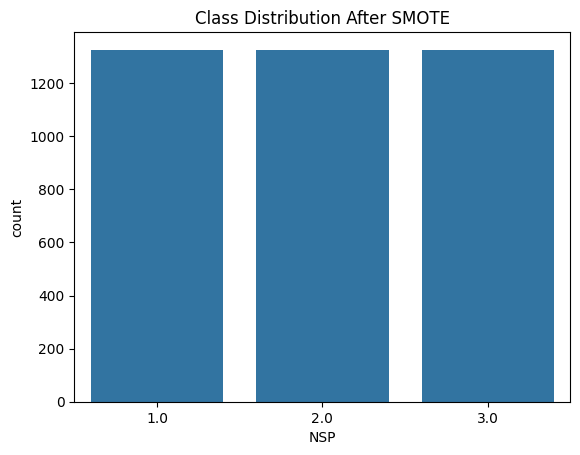

In [63]:
# Apply SMOTE oversampling on training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_res).value_counts().to_dict())

sns.countplot(x=y_train_res)
plt.title("Class Distribution After SMOTE")
plt.show()


In [64]:
processed_path = Path("data/processed")
processed_path.mkdir(exist_ok=True)

# Save scaled datasets
X_train_res.to_csv(processed_path / "X_train_res.csv", index=False)
y_train_res.to_csv(processed_path / "y_train_res.csv", index=False)
X_test_scaled.to_csv(processed_path / "X_test.csv", index=False)
y_test.to_csv(processed_path / "y_test.csv", index=False)

# Save scaler
joblib.dump(scaler, processed_path / "scaler_ctg.pkl")

print("Preprocessed data and scaler saved in:", processed_path)


Preprocessed data and scaler saved in: data/processed


In [65]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1703, 21)
y_train shape: (1703,)
X_test shape: (426, 21)
y_test shape: (426,)


In [66]:
set(X_train.columns) == set(X_test.columns)


True

In [67]:
print("Training target distribution:\n", y_train.value_counts(normalize=True))
print("\nTest target distribution:\n", y_test.value_counts(normalize=True))


Training target distribution:
 NSP
1.0    0.778626
2.0    0.138579
3.0    0.082795
Name: proportion, dtype: float64

Test target distribution:
 NSP
1.0    0.779343
2.0    0.138498
3.0    0.082160
Name: proportion, dtype: float64


In [68]:
print("Missing values in X_train:", X_train.isna().sum().sum())
print("Missing values in X_test:", X_test.isna().sum().sum())


Missing values in X_train: 0
Missing values in X_test: 0
